# Colab

In [ ]:
!git clone https://github.com/Tio-Panda/inf577-project.git

# Init

In [ ]:
%load_ext autoreload
%autoreload 2

import sys
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as patches

base_path = "." # local
#base_path = "/content/inf577-project" # colab

sys.path.append(f"{base_path}/modules")

import tensorflow as tf
import keras
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

dataset_path = f"{base_path}/dataset_test/"
training_path = f"{base_path}/data/training/"
checkpoint_path = f"{base_path}/weights/"

Ns = 2800
Nc = 128
Nz = 2048
Nx = 256

from modules import DataLoader
dl = DataLoader(dataset_path, f"{base_path}/data.csv")

import gc; gc.collect()

2025-09-10 04:49:43.203190: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757490583.220014  601199 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757490583.225927  601199 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1757490583.240151  601199 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1757490583.240175  601199 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1757490583.240177  601199 computation_placer.cc:177] computation placer alr

0

# Figures functions

In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def get_bmode_to_ax(ax, desc, bmode, grid, vmin=-50, vmax=0):
    zlims = grid[:, 0, 2] * 1e3
    xlims = grid[0, :, 0] * 1e3

    ax.imshow(bmode, vmin=vmin, vmax=vmax, cmap='gray',
        extent=(xlims[0], xlims[-1], zlims[-1], zlims[0]),
        origin='upper', aspect='auto')
    ax.set_title(desc)
    ax.axis('off')
    
    return ax

def paint_roi(ax, bbox, grid, bmode, color="red"):
    z, x, h, w = bbox

    zlims = grid[:, 0, 2] * 1e3
    xlims = grid[0, :, 0] * 1e3

    dx = (xlims[-1] - xlims[0]) / bmode.shape[1]
    dz = (zlims[0] - zlims[-1]) / bmode.shape[0]

    x_start = xlims[0] + x * dx
    z_start = zlims[0] - z * dz

    rect = patches.Rectangle((x_start, z_start), w*dx, h*dz,
                         linewidth=1, edgecolor=color, facecolor='none')
    ax.add_patch(rect)

    return ax

def put_roi_zoom(ax, bbox, grid, bmode, color="red", vmin=-50, vmax=0):
    z, x, h, w = bbox

    zlims = grid[:, 0, 2] * 1e3
    xlims = grid[0, :, 0] * 1e3

    dx = (xlims[-1] - xlims[0]) / bmode.shape[1]
    dz = (zlims[0] - zlims[-1]) / bmode.shape[0]

    x_start = xlims[0] + x * dx
    z_start = zlims[0] - z * dz

    axins = inset_axes(ax, width="25%", height="25%", loc='upper right', borderpad=1)
    axins.imshow(bmode, vmin=vmin, vmax=vmax, cmap='gray',
                extent=(xlims[0], xlims[-1], zlims[-1], zlims[0]),
                origin='upper', aspect='auto')
    axins.set_xlim(x_start, x_start+w*dx)
    axins.set_ylim(z_start, z_start+h*dz)
    axins.axis('off')

    border = patches.Rectangle(
        (x_start, z_start),
        w*dx, h*dz,
        linewidth=2, edgecolor=color, facecolor='none',
        transform=axins.transData, zorder=12
    )
    axins.add_patch(border)

    return ax

# Metrics

In [4]:
import time
from modules import ReconstructionRF, get_grid, get_bmode
from modules import load_data

def cnr(img1, img2):
    return np.abs(img1.mean() - img2.mean()) / np.sqrt(np.var(img1, ddof=0) + np.var(img2, ddof=0))

def gcnr(img1, img2):
    _, bins = np.histogram(np.concatenate((img1, img2)), bins=256)
    f, _ = np.histogram(img1, bins=bins, density=True)
    g, _ = np.histogram(img2, bins=bins, density=True)
    f /= f.sum()
    g /= g.sum()
    return 1 - np.sum(np.minimum(f, g))

def eval_metrics(inputs, bmode, vmin, vmax):
    z1, x1, h1, w1 = inputs["bbox1"]
    z2, x2, h2, w2 = inputs["bbox2"]

    bmode = np.clip(bmode, vmin, vmax)

    roi1 = bmode[z1:z1+h1, x1:x1+w1]
    roi2 = bmode[z2:z2+h2, x2:x2+w2]

    o = { "cnr": 0, "gcnr": 0 }

    o["cnr"] = cnr(roi1, roi2)
    o["gcnr"] = gcnr(roi1, roi2)

    return o

In [5]:
import h5py

def get_img_metrics(inputs, dataset_path, vmin, vmax):
    o = {}
    for i in inputs:
        o[i["name"]] = []

    _o = {}
    for i in inputs:
        with h5py.File(dataset_path+i["name"]+".hdf5", "r") as f:
            img = np.array(f["img"]).astype(np.float32)
            das = np.array(f["das"]).astype(np.float32)
            grid = np.array(f["grid"]).astype(np.float32)

        _o = {}
        _o["grid"] = grid
        _o["title"] = f"a) DAS a:35 (F#=1)"
        _o["img"] = das
        _o["bmode"] = get_bmode(_o["img"])
        _o["metrics"] = eval_metrics(i, _o["bmode"], vmin, vmax)
        _o["bbox1"] = i["bbox1"]
        _o["bbox2"] = i["bbox2"]

        o[i["name"]].append(_o)

        _o = {}
        _o["grid"] = grid
        _o["title"] = f"b) MVB {75}"
        _o["img"] = img
        _o["bmode"] = get_bmode(_o["img"])
        _o["metrics"] = eval_metrics(i, _o["bmode"], vmin, vmax)
        _o["bbox1"] = i["bbox1"]
        _o["bbox2"] = i["bbox2"]

        o[i["name"]].append(_o)

        
        letters = ["c", "d", "e"]
        for idx, m_name in enumerate(["model-1", "model-2", "model-3"]):
            _o = {}
            _o["grid"] = grid
            _o["title"] = f"{letters[idx]}) Model-{idx+1}"

            custom_obj = {
                "LeakyReLU": keras.layers.LeakyReLU,
            }
            model = keras.saving.load_model(
                checkpoint_path+m_name+".keras",
                custom_objects=custom_obj
            )

            input, _ = load_data(i["name"], dataset_path)

            _o["img"] = model.predict(input)
            _o["bmode"] = get_bmode(_o["img"][0, ..., 0])
            _o["metrics"] = eval_metrics(i, _o["bmode"], vmin, vmax)
            _o["bbox1"] = i["bbox1"]
            _o["bbox2"] = i["bbox2"]

            o[i["name"]].append(_o)


    return o

# Get reconstructions and calculate metrics

In [6]:
inputs = [
    {
        "name": "contrast_speckle_expe_dataset_rf",
        "bbox1": [1780, 118, 130, 19],
        "bbox2": [1780, 90, 130, 19],
        "roi": True
    },
    {
        "name": "contrast_speckle_simu_dataset_rf",
        "bbox1": [1830, 114, 280, 28],
        "bbox2": [1830, 75, 280, 28],
        "roi": True
    },
    {
        "name": "resolution_distorsion_expe_dataset_rf",
        "bbox1": [1190, 44, 268, 27],
        "bbox2": [1190, 90, 268, 27],
        "roi": True
    },
    {
        "name": "carotid_cross_expe_dataset_rf",
        "bbox1": [1780, 118, 130, 19], # Dan igual ya que los roi es para calcular cnr y gcnr
        "bbox2": [1780, 90, 130, 19], # Dan igual ya que los roi es para calcular cnr y gcnr
        "roi": False
    },
    {
        "name": "carotid_long_expe_dataset_rf",
        "bbox1": [1830, 114, 280, 28], # Dan igual ya que los roi es para calcular cnr y gcnr
        "bbox2": [1830, 75, 280, 28], # Dan igual ya que los roi es para calcular cnr y gcnr
        "roi": False
    },
]

vmin = -50
vmax = 0

o = get_img_metrics(inputs, dataset_path, vmin=vmin, vmax=0)

I0000 00:00:1757490586.411034  601199 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21768 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:2b:00.0, compute capability: 8.6
I0000 00:00:1757490587.248410  601365 service.cc:152] XLA service 0x7a8b100463f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1757490587.248480  601365 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2025-09-10 04:49:47.268887: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1757490587.302214  601365 cuda_dnn.cc:529] Loaded cuDNN version 91002


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


I0000 00:00:1757490588.246794  601365 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 509ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step


# Show figures

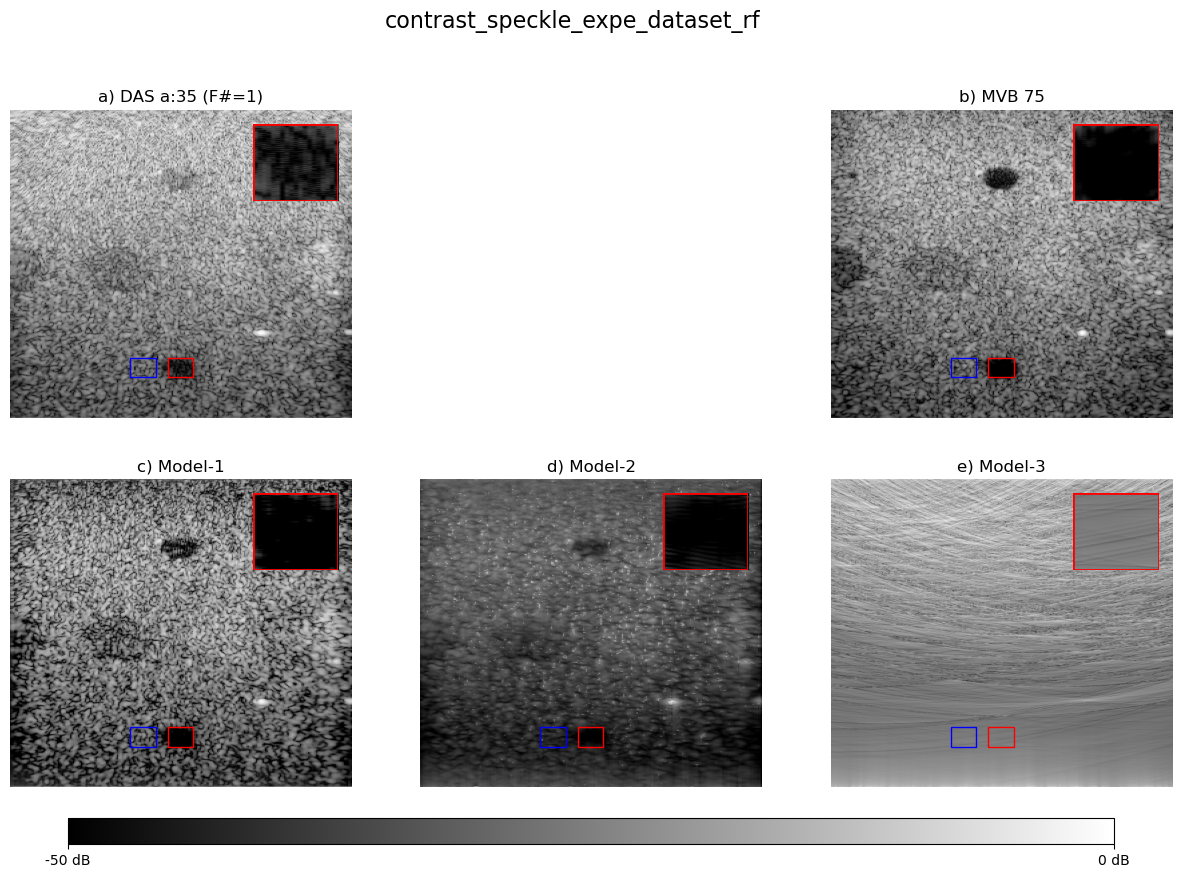

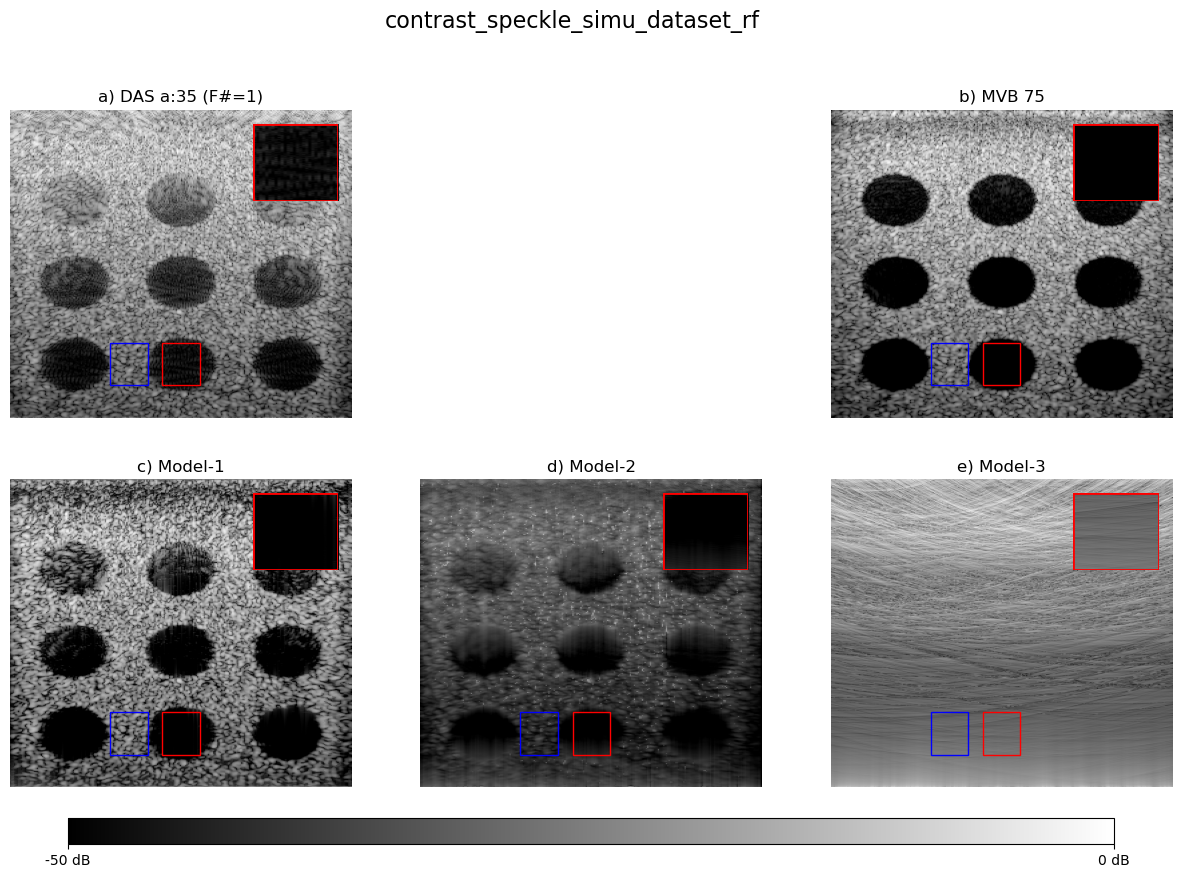

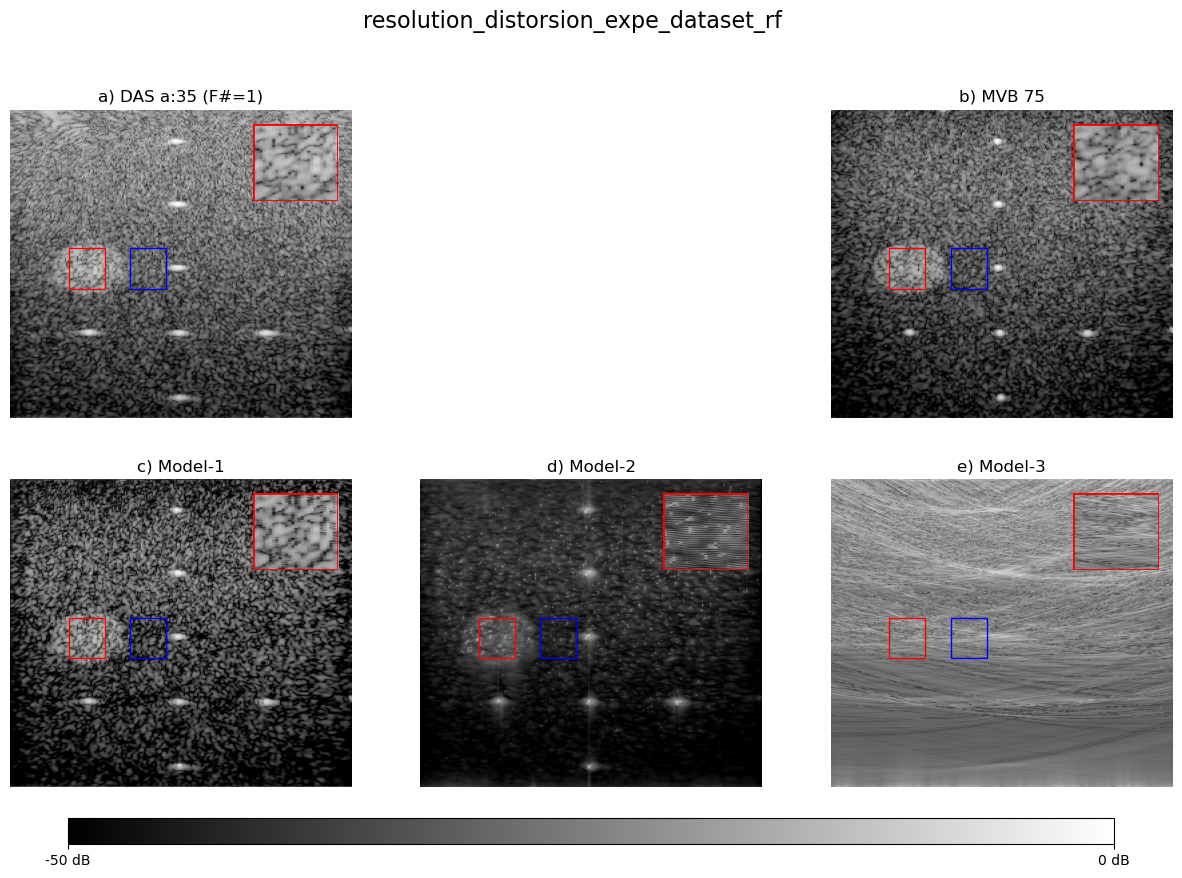

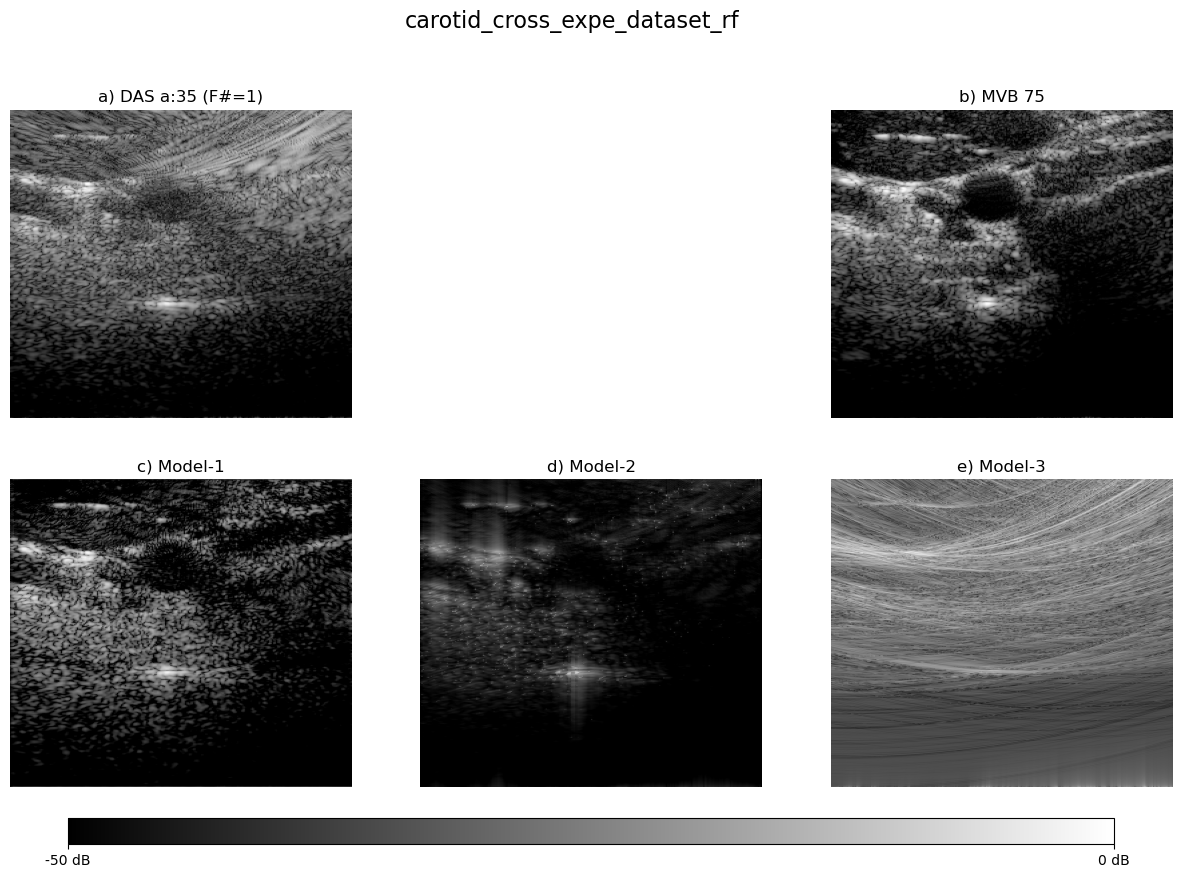

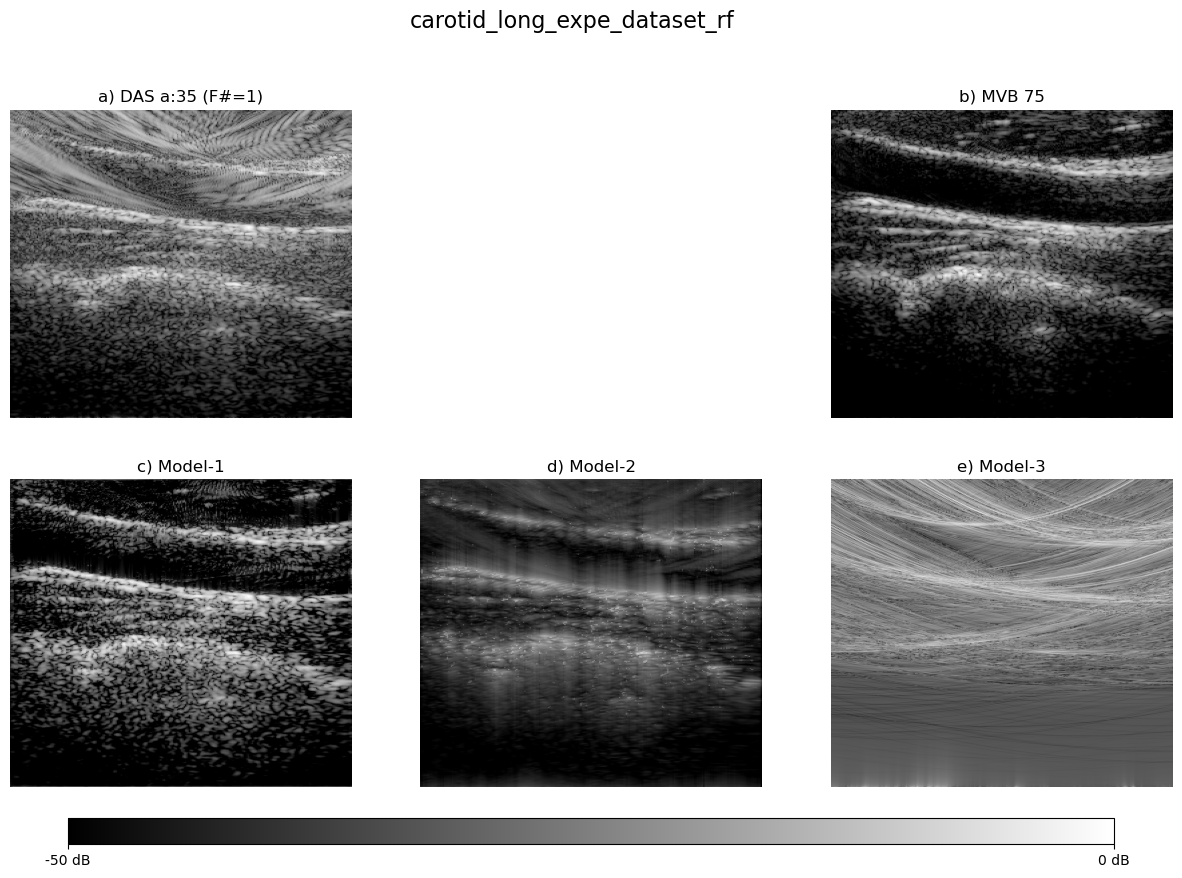

In [ ]:
import pandas as pd
from matplotlib.gridspec import GridSpec

def show_figures(inputs, data, vmin, vmax):
    for i in inputs:

        fig = plt.figure(figsize=(15, 10))
        gs = GridSpec(2, 3, figure=fig)

        ax1 = fig.add_subplot(gs[0, 0])
        ax2 = fig.add_subplot(gs[0, 2])

        ax3 = fig.add_subplot(gs[1, 0])
        ax4 = fig.add_subplot(gs[1, 1])
        ax5 = fig.add_subplot(gs[1, 2])

        axes = [ax1, ax2, ax3, ax4, ax5]

        name = i["name"]
        roi = i["roi"]
        _data = data[name]

        for ax, __data in zip(axes, _data):
            ax = get_bmode_to_ax(ax, __data["title"], __data["bmode"], __data["grid"], vmin=vmin)

            if roi:
                ax = paint_roi(ax, __data["bbox1"], __data["grid"], __data["bmode"], color="red")
                ax = put_roi_zoom(ax, __data["bbox1"], __data["grid"], __data["bmode"], color="red", vmin=vmin)
                ax = paint_roi(ax, __data["bbox2"], __data["grid"], __data["bmode"], color="blue")

        mappable = axes[-1].images[0]
        cbar = fig.colorbar(mappable, ax=axes, orientation="horizontal", fraction=0.08, pad=0.04, shrink=0.9, aspect=40)
        cbar.set_ticks([vmin, vmax])
        cbar.set_ticklabels([f"{vmin:d} dB", f"{vmax:d} dB"])
        
        fig.suptitle(name, fontsize=16)

        fig.savefig(f"{base_path}/figures/"+name+".png", dpi=300, bbox_inches="tight")

        plt.show()

show_figures(inputs, o, vmin=vmin, vmax=vmax)

# Get and show CNR and gCNR tables

In [ ]:
import pandas as pd

def get_contrast_metrics(inputs, data):
    for i in inputs[0:3]:
        name = i["name"]
        _data = data[name][2:]

        metrics = [item["metrics"] for item in _data]
        df = pd.DataFrame(metrics)
        df.index = [f"Model-{i+1}" for i in range(3)]
        df = df.round(5)
        
        df.to_csv(f"{base_path}/metric_tables/c_{name}.csv")

get_contrast_metrics(inputs, o)

In [17]:
import os
import glob

csv_files = glob.glob(os.path.join(f"{base_path}/metric_tables", "c_*.csv"))

for file in csv_files:
    base_name = os.path.splitext(os.path.basename(file))[0]
    name = base_name.replace("c_", "")
    df = pd.read_csv(file)

    print(name)
    display(df)


contrast_speckle_expe_dataset_rf


Unnamed: 0      cnr     gcnr
0    Model-1  0.18615  0.21579
1    Model-2  0.08061  0.18907
2    Model-3  0.14499  0.18866

contrast_speckle_simu_dataset_rf


Unnamed: 0      cnr     gcnr
0    Model-1  0.17583  0.18513
1    Model-2  0.13900  0.19299
2    Model-3  0.16304  0.14171

resolution_distorsion_expe_dataset_rf


Unnamed: 0      cnr     gcnr
0    Model-1  0.07398  0.13322
1    Model-2  0.62535  0.35268
2    Model-3  0.11356  0.12023

# Get and show MSLE table

In [23]:
from sklearn.metrics import mean_squared_log_error

def get_msle_table(inputs):
    msle_output = {}
    for i in inputs:
        msle_output[i["name"]] = []


    custom_obj = {
        "LeakyReLU": keras.layers.LeakyReLU,
    }

    for i in inputs:
        name = i["name"]
        input, img2 = load_data(name, dataset_path)

        for _, m_name in enumerate(["model-1", "model-2", "model-3"]):
            
            model = keras.saving.load_model(
                checkpoint_path+m_name+".keras",
                custom_objects=custom_obj
            )

            img1 = model.predict(input)[0, ..., 0]
            img1 = (img1 - np.min(img1)) / (np.max(img1) - np.min(img1))

            img2 = (img2 - np.min(img2)) / (np.max(img2) - np.min(img2))

            msle = mean_squared_log_error(img2.ravel(), img1.ravel())
            msle_output[name].append(msle)

    df = pd.DataFrame(msle_output)
    df = df.T
    df.columns = ["Model-1", "Model-2", "Model-3"]

    df.loc["mean"] = df.mean()
    df = df.round(5)

    df.to_csv(f"{base_path}/metric_tables/msle.csv")

get_msle_table(inputs)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 515ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step


In [24]:
df = pd.read_csv(f"{base_path}/metric_tables/msle.csv")

display(df)

Unnamed: 0  Model-1  Model-2  Model-3
0       contrast_speckle_expe_dataset_rf  0.00050  0.02248  0.04896
1       contrast_speckle_simu_dataset_rf  0.00100  0.06147  0.05365
2  resolution_distorsion_expe_dataset_rf  0.00038  0.02152  0.02274
3          carotid_cross_expe_dataset_rf  0.00021  0.03643  0.01953
4           carotid_long_expe_dataset_rf  0.00031  0.01016  0.02636
5                                   mean  0.00048  0.03041  0.03425